In [1]:
# Copyright © 2020 Intel Corporation.
#
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy,
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
#
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are
# expressly stated in the License.

# Image classification: MNIST

## Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Enable SLURM to run network on Loihi.
os.environ['SLURM'] = '1'
os.environ['PYTHONUNBUFFERED'] = '1'

snipDir = os.path.abspath(os.path.join('..', 'snips', 'reset_model_states'))

## Introduction

Deep neural networks can be executed on Loihi via the NxTF interface:
- NxTF provides a set of custom Keras layers that can be used to define feedforward networks (currently only convolutional layers).
- NxTF also comes with a special DNN compiler that distributes individual layers accross multiple Loihi cores in an optimal way using Loihi's connectivity compression featuers.
- NxTF connects directly to Loihi and provides interactive access to network state.

DNNs can currently be configured in one of two ways:
- SLAYER can be used to train DNNs offline and its output can be converted to build a Keras model using NxLayers.
- Traditional (off-the-shelf) ANNs can be converted using the SNN-Toolbox to an equivalent SNN represenation. 

In this tutorial we go the latter route and define and train an ANN in Keras for MNIST which then gets converted into a Loihi spiking model.

![](figures/NxTF_Overview.png "Overview")

## Parameter definition

In [3]:
batch_size = 32
num_training_epochs = 2
input_shape = (28, 28, 1)

num_steps_per_img = 512
num_train_samples = 60000
num_test_samples = 128

# EnergyProbes allow to profile execution time, power and thus energy consumption
enable_energy_probe = True
execution_time_probe_bin_size = 512 # Small numbers slows down execution

# Not yet supported
measure_accuracy_runtime_trade_off = False # Not yet supported
runtimes = [128, 256, 512, 1024, 2048]

## Load dataset


In [4]:
from keras.datasets import mnist
from keras.utils import np_utils

# Load standard MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize input so we can train ANN with it. 
# Will be converted back to integers for SNN layer.
x_train = x_train[:num_train_samples, :, :] / 255
x_test = x_test / 255

# Add a channel dimension.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# One-hot encode target vectors.
y_train = np_utils.to_categorical(y_train[:num_train_samples], 10)
y_test = np_utils.to_categorical(y_test, 10)

## Setup DNN in Keras
Here we create a conventional DNN through the native Keras interface and train the model on the provided dataset on the super host (the training is not happening on Loihi). Alternatively, we can load a pre-trained model to save time.

In [5]:
import os
import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Conv2D, Input
    
train_model = False
    
# Path for pre-trained model
# Path for pre-trained model
pretrained_model_path = os.path.join(os.path.abspath(''),
                                     'models', 
                                     'a_minist_model.h5')
    
# Generate model
if train_model or not os.path.isfile(pretrained_model_path):
    # Define model
    input_layer = Input(input_shape)

    layer = Conv2D(filters=16, 
                   kernel_size=(5, 5), 
                   strides=(2, 2), 
                   input_shape=input_shape,
                   activation='relu')(input_layer)
    layer = Dropout(0.1)(layer)
    layer = Conv2D(filters=32, 
                   kernel_size=(3, 3), 
                   activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Conv2D(filters=64, 
                   kernel_size=(3, 3), 
                   strides=(2, 2), 
                   activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Conv2D(filters=10, 
                   kernel_size=(4, 4), 
                   activation='softmax')(layer)
    layer = Flatten()(layer)

    ann_model = Model(input_layer, layer)

    ann_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    
    # Training 
    ann_model.fit(x_train, y_train, batch_size, num_training_epochs, verbose=2,
          validation_data=(x_test, y_test))
    
    # Save model
    ann_model.save(pretrained_model_path)
else:
    # Load pre-trained model
    ann_model = keras.models.load_model(pretrained_model_path)
    
ann_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        416       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 64)          0         
__________

## Create Loihi model
Here we expose what would otherwise happen within the SNN-Toolbox
### Setup spiking model

In [6]:
from nxsdk_modules_ncl.dnn.src.utils import extract
from nxsdk_modules_ncl.dnn.src.dnn_layers import NxInputLayer, NxConv2D, \
    NxModel, ProbableStates

vth_mant = 2**9
bias_exp = 6
weight_exponent = 0
synapse_encoding = 'sparse'

inputLayer = NxInputLayer(input_shape, 
                             vThMant=vth_mant, 
                             biasExp=bias_exp)
        
layer = NxConv2D(filters=16, 
                 kernel_size=(5, 5), 
                 strides=(2, 2), 
                 input_shape=input_shape,
                 vThMant=vth_mant,
                 weightExponent=weight_exponent,
                 synapseEncoding=synapse_encoding)(inputLayer.input)
layer = NxConv2D(filters=32, 
                 kernel_size=(3, 3), 
                 vThMant=vth_mant,
                 weightExponent=weight_exponent,
                 synapseEncoding=synapse_encoding)(layer)
layer = NxConv2D(filters=64, 
                 kernel_size=(3, 3), 
                 strides=(2, 2), 
                 vThMant=vth_mant,
                 weightExponent=weight_exponent,
                 synapseEncoding=synapse_encoding)(layer)
layer = NxConv2D(filters=10, 
                 kernel_size=(4, 4), 
                 activation='softmax', 
                 vThMant=vth_mant,
                 weightExponent=weight_exponent,
                 synapseEncoding=synapse_encoding)(layer)

snn_nxmodel = NxModel(inputLayer.input, layer,
                        numCandidatesToCompute=1)

snn_nxmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (NxInputLayer)       (None, 28, 28, 1)         0         
_________________________________________________________________
nx_conv2d_1 (NxConv2D)       (None, 12, 12, 16)        416       
_________________________________________________________________
nx_conv2d_2 (NxConv2D)       (None, 10, 10, 32)        4640      
_________________________________________________________________
nx_conv2d_3 (NxConv2D)       (None, 4, 4, 64)          18496     
_________________________________________________________________
nx_conv2d_4 (NxConv2D)       (None, 1, 1, 10)          10250     
Total params: 33,802
Trainable params: 33,802
Non-trainable params: 0
_________________________________________________________________


### Convert floating point weights to 8-bit integers

In [7]:
from nxsdk_modules_ncl.dnn.src.utils import to_integer

# Extract weights and biases from parameter list.
parameters = ann_model.get_weights()
weights = parameters[0::2]
biases = parameters[1::2]

# Quantize weights and biases using max-normalization (Strong quantization loss if distributions have large tails)
parameters_int = []
for w, b in zip(weights, biases):
    w_int, b_int = to_integer(w, b, 8)
    parameters_int += [w_int, b_int]

# Set quantized weigths and biases for spiking model
snn_nxmodel.set_weights(parameters_int)

### Show parameter distribution

In [8]:
def plotParamDist(params, params_int, max_val, num_bins=64):
    num_layers = len(params)
    for i, (p1, p2) in enumerate(zip(params, params_int)):
        plt.subplot(1, num_layers, i+1)
        scaled_p = np.ndarray.flatten(p1/max_val*255)
        _, bins, _ = plt.hist(scaled_p, bins=num_bins, label='float (scaled)')
        _ = plt.hist(np.ndarray.flatten(p2), bins=bins, alpha=0.5, label='int')
        plt.title("Layer {}".format(i+1))
        plt.legend(loc='upper left')

#### Weight distribution

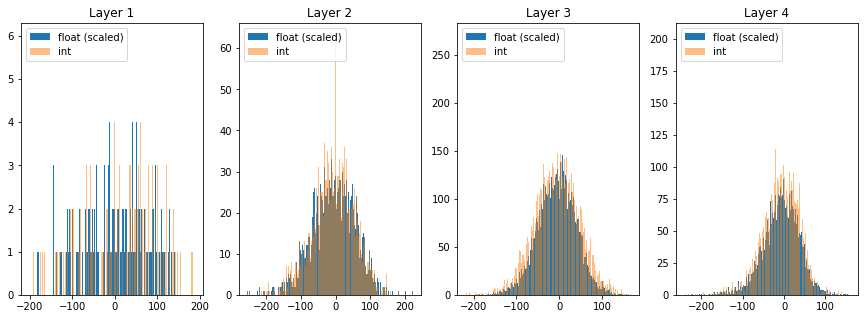

In [9]:
weights_int = parameters_int[0::2]
biases_int = parameters_int[1::2]
max_val = [np.max(np.abs(np.concatenate([w, b], None))) for w, b in zip(weights, biases)]
max_val = np.max(max_val)

plt.figure(figsize=(15,5))
plotParamDist(weights, weights_int, max_val, num_bins=512)

#### Bias distribution

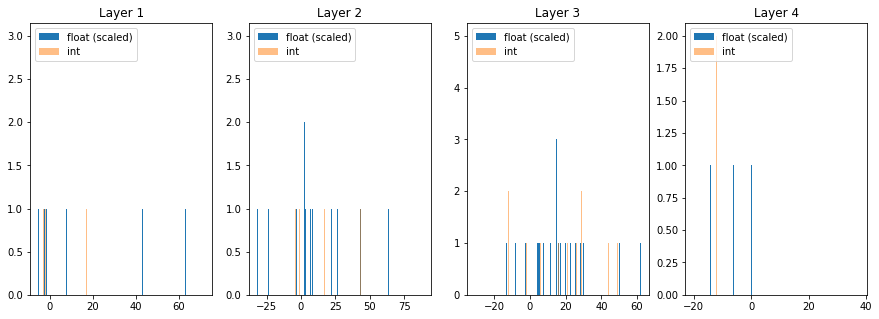

In [10]:
plt.figure(figsize=(15,5))
plotParamDist(biases, biases_int, max_val, num_bins=512)

## Instantiate composable DNN and InputGenerator

In [17]:
from nxsdk_modules_ncl.dnn.composable.composable_dnn import ComposableDNN as DNN
from nxsdk_modules.input_generator.input_generator import InputGenerator

# NxModel is not yet implemented as a Composable -> Wrap it with DNN composable class
dnn = DNN(model=snn_nxmodel, num_steps_per_img=num_steps_per_img)

input_generator = InputGenerator(shape=input_shape, interval=num_steps_per_img)

input_generator.setBiasExp(bias_exp)

## Create Model pipeline, Add and Connect composables

In [13]:
from nxsdk.composable.model import Model
from nxsdk.logutils.nxlogging import set_verbosity,LoggingLevel
set_verbosity(LoggingLevel.ERROR)

# Initialize empty model
snn_model = Model("dnn_model")

# Add DNN and InputGenerator to empty model
snn_model.add(dnn)
snn_model.add(input_generator)

# Connect InputGenerator to DNN
# (Explicit)
# input_generator.ports.output.connect(dnn.ports.input)
# (Implicit when ports can be inferred)
input_generator.connect(dnn)

# Enfore particular execution order or processes/snips executing in the same phase
# (Here: Execute input injection as bias currents after network reset)
input_generator.processes.inputEncoder.executeAfter(dnn.processes.reset)

## Compilation

Compile the entire model: This compiles all composables. Compiling a composable invokes partition/map/updatePorts on each of them. Aggregates all processes across all composables to create snips grouped by chip/lmt/phase. Finally, each composable can attach channels to snips and complete the connectivity once the full board utilization is known across all composables. See `Composable` documentation.

In [14]:
snn_model.compile()

x

....x

................x

...x

x



## Set up EnergyProbe

In [15]:
if enable_energy_probe:
    from nxsdk.api.enums.api_enums import ProbeParameter
    from nxsdk.graph.monitor.probes import PerformanceProbeCondition
    eProbe = snn_model.board.probe(
        probeType=ProbeParameter.ENERGY, 
        probeCondition=PerformanceProbeCondition(
            tStart=1, 
            tEnd=num_test_samples*num_steps_per_img, 
            bufferSize=1024, 
            binSize=execution_time_probe_bin_size))

## Start the model

In [16]:
snn_model.start(snn_nxmodel.board)

## Define run function

In [16]:
def runModel(num_steps_per_sample, x_test, y_test):
    """Runs the SNN Model to classify test images."""
      
    # Initialize arrays for results
    num_samples = len(y_test)
    classifications = np.zeros(num_samples, int)
    labels = np.zeros(num_samples, int)

    # Run DNN to classify images
    tStart = time.time()
    snn_model.run(num_steps_per_sample * num_samples, aSync=True)
    tEndBoot = time.time()

    # Enqueue images by pushing them into InputGenerator
    print("Queuing images...")
    for i, (x, y) in enumerate(zip((x_test* 255).astype(int), y_test)):
        input_generator.encode(x)
        labels[i] = np.argmax(y)
    tEndInput = time.time()

    # Read out classification results for all images
    print("Waiting for classification to finish...")
    classifications = list(dnn.readout_channel.read(num_samples))
    tEndClassification = time.time()
    
    # finishRun fetches EnergyProbe data if configured
    snn_model.finishRun()
    
    return tStart, tEndBoot, tEndInput, tEndClassification, classifications, labels

def calcAccuracy(classifications, labels):
    """Computes classification accuracy for a set of images given classification and labels."""
    errors = classifications != labels
    num_errors = np.sum(errors)
    num_samples = len(classifications)
    return (num_samples-num_errors)/num_samples

## Classify images with spiking model

In [17]:
tStart, tEndBoot, tEndInput, tEndClassification, classifications, labels = runModel(num_steps_per_img, 
                                                                                    x_test[:num_test_samples, :, :], 
                                                                                    y_test[:num_test_samples])

Queuing images...spikes... . 
Waiting for classification to finish...


In [18]:
if not measure_accuracy_runtime_trade_off:
    snn_model.disconnect()

## Show results

### Define plotting function

In [19]:
def plot_samples(samples, guesses, lables, numCols=5, size=28):
    """Plots samples as an array of images."""
    
    import math
    numSamples = len(samples)
    numRows = int(math.ceil(numSamples/numCols))
    plt.figure(3, figsize=(20, 10))
    i = 0
    for c in range(numCols):
        for r in range(numRows):
            plt.subplot(numRows, numCols, i+1)
            plt.imshow(np.reshape(samples[i,:], (size, size)))
            plt.axis('off')
            plt.title('C:{}/L:{}'.format(guesses[i], lables[i]))
            i += 1
            if i == numSamples:
                break
        if i == numSamples:
            break
    plt.show()

### Classification results
Note: Since we are not using SNN-Toolbox in this example and instead convert weights from SNN to ANN manually without consideration of SNN saturation of weight clipping, classification accuracies can sometimes be bad.

Runtime statistics including boot, input generation and classification:
-----------------------------------------------------------------------
    Runtime till end of boot: 0.986 s
    Runtime till end of input queueing: 2.713 s
    Runtime till end of classification: 4.994 s
    Effective average time per time step: 76.210us
    Effective average classification time per sample: 39.019ms

Accuracy metrics:
    Number of incorrect classifications: 2 of 128
    Classification accuracy: 98.44%

Some correct classifications:


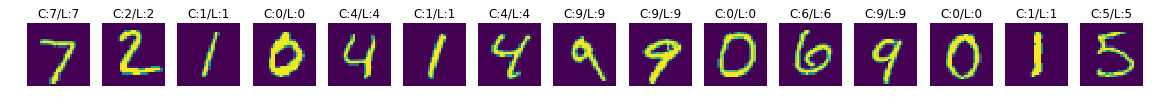

Incorrect classifications:


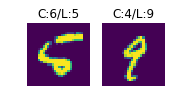

In [20]:
# Runtime statistics
runtimeBoot = tEndBoot-tStart
runtimeInput = tEndInput-tStart
runtimeClassification = tEndClassification-tStart
print("Runtime statistics including boot, input generation and classification:")
print("-----------------------------------------------------------------------")
print("    Runtime till end of boot: {:.3f} s".format(runtimeBoot))
print("    Runtime till end of input queueing: {:.3f} s".format(runtimeInput))
print("    Runtime till end of classification: {:.3f} s".format(runtimeClassification))
print("    Effective average time per time step: %.3fus"%(runtimeClassification*1e6/(num_test_samples*num_steps_per_img)))
print("    Effective average classification time per sample: %.3fms"%(runtimeClassification*1e3/num_test_samples))
print("")

# Accuracy statistics
errors = classifications != labels
num_errors = np.sum(errors)
print("Accuracy metrics:")
print("    Number of incorrect classifications: {} of {}".format(num_errors, num_test_samples))
print("    Classification accuracy: {:.2%}".format((num_test_samples-num_errors)/num_test_samples))
print("")

# Show some correctly classified images
maxShow = 15
if num_errors < num_test_samples:
    print("Some correct classifications:")
    correct_idx = np.where(errors==0)[0]
    correct_idx = correct_idx[:min([maxShow, len(correct_idx)])]
    plot_samples(
        samples=x_test[correct_idx], 
        guesses=[classifications[i] for i in correct_idx], 
        lables=[labels[i] for i in correct_idx], 
        numCols=15)

# Show incorrectly classified images
if num_errors > 0:
    print("Incorrect classifications:")
    error_idx = np.where(errors)[0]
    error_idx = error_idx[:min([maxShow, len(correct_idx)])]
    plot_samples(
        samples=x_test[error_idx], 
        guesses=[classifications[i] for i in error_idx], 
        lables=[labels[i] for i in error_idx], 
        numCols=15)

### Performance statistics

In [21]:
if enable_energy_probe:
    import numpy as np
    print("Runtime statistics including input generation and classification:")
    print("-----------------------------------------------------------------")
    print("Average time per time step: %.3fus"%(np.mean(eProbe.totalTimePerTimeStep)))
    print("Average spiking time per time step: %.3fus"%(np.mean(eProbe.spikingTimePerTimeStep)))
    print("Average management time per time step: %.3fus"%(np.mean(eProbe.managementTimePerTimeStep)))
    print("Average classification time per sample: %.3fms"%(np.mean(eProbe.spikingTimePerTimeStep)*num_steps_per_img/1e3))
    print("Average I/O time per sample: %.3fms"%(np.mean(eProbe.managementTimePerTimeStep)*num_steps_per_img/1e3))

Runtime statistics including input generation and classification:
-----------------------------------------------------------------
Average time per time step: 60.807us
Average spiking time per time step: 57.364us
Average management time per time step: 3.444us
Average classification time per sample: 29.370ms
Average I/O time per sample: 1.763ms


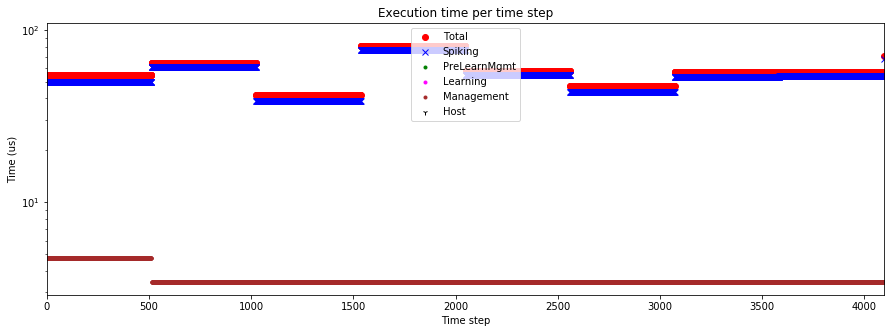

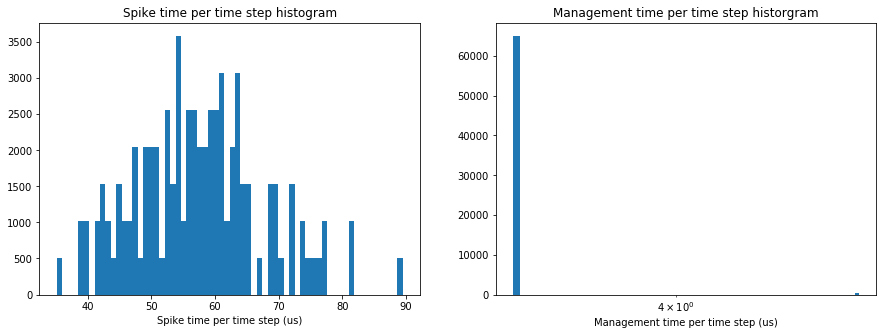

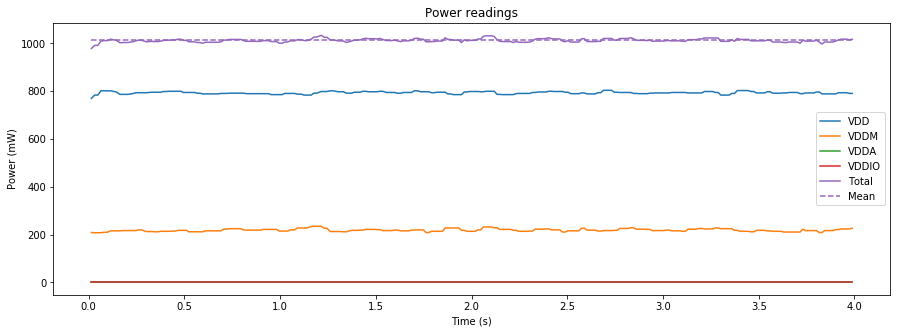

In [22]:
num_img_to_plot = 8

if enable_energy_probe:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15,5))
    eProbe.plotExecutionTime()
    plt.xlim(0, num_steps_per_img*num_img_to_plot)
    plt.gca().set_yscale('log')
    plt.legend(loc='upper center')
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(eProbe.spikingTimePerTimeStep, bins=64)
    plt.xlabel('Spike time per time step (us)')
    plt.title("Spike time per time step histogram")
    
    plt.subplot(1, 2, 2)
    plt.hist(eProbe.managementTimePerTimeStep, bins=64)
    plt.gca().set_xscale('log')
    plt.xlabel('Management time per time step (us)')
    plt.title("Management time per time step historgram")
    
    # Note: Power measurements won't be accurate for small binSizes due to frequent executionTimeBuffer transfers
    plt.figure(figsize=(15, 5))
    eProbe.plotPower()